In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [3]:
len(list(data_dir.glob('*/*.jpg')))

3670

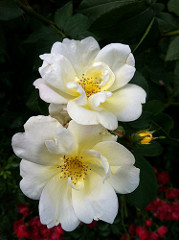

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

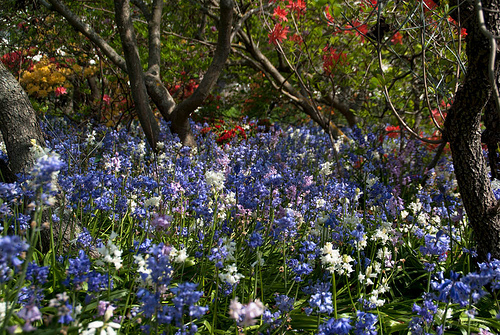

In [5]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[1]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    seed = 123, 
    image_size = (img_height, img_width), 
    batch_size= batch_size,
    validation_split = 0.2, 
    subset = 'training')

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'validation',
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


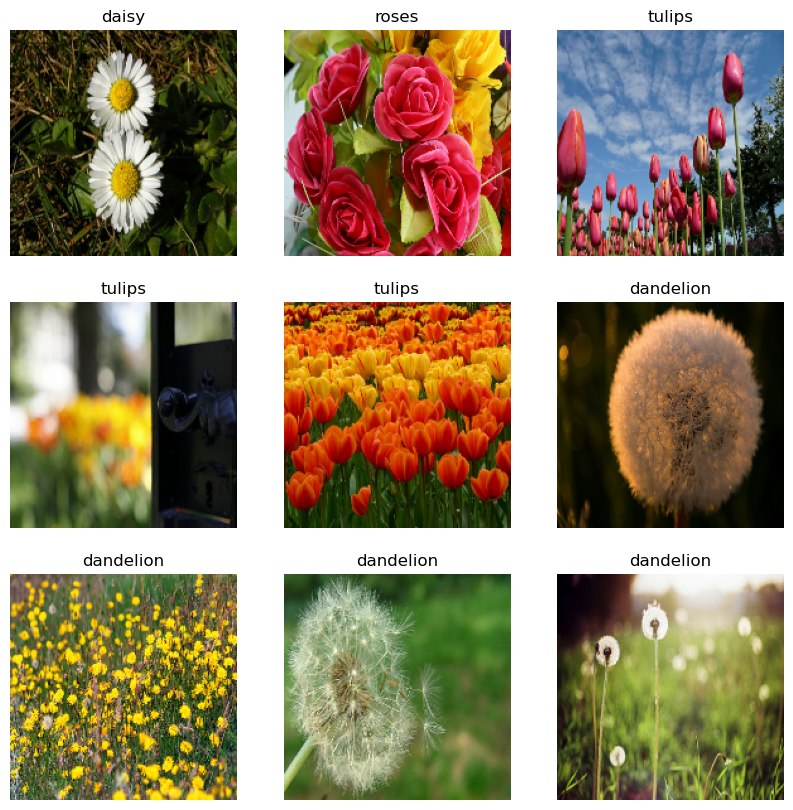

In [10]:
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(2):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [11]:
i = 0
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [13]:
normalization_layer = layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x,y:(normalization_layer(x), y))
image_batch, label_batch = next(iter(normalized_ds))
image = image_batch[0]
print(np.max(image), np.min(image))

0.9990197 0.0


In [15]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes)
])

c:\Users\muham\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.3713 - loss: 1.4690 - val_accuracy: 0.5940 - val_loss: 1.0588
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.6367 - loss: 0.9551 - val_accuracy: 0.6540 - val_loss: 0.8853
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.7406 - loss: 0.7231 - val_accuracy: 0.6281 - val_loss: 0.9661
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.8214 - loss: 0.5213 - val_accuracy: 0.6608 - val_loss: 0.8835
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9059 - loss: 0.3008 - val_accuracy: 0.6458 - val_loss: 1.1472
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9469 - loss: 0.1815 - val_accuracy: 0.6649 - val_loss: 1.2652
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.9764 - loss: 0.0931 - val_accuracy: 0.6376 - val_loss: 1.5065
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.9903 - loss: 0.0517 - val_accuracy: 0.

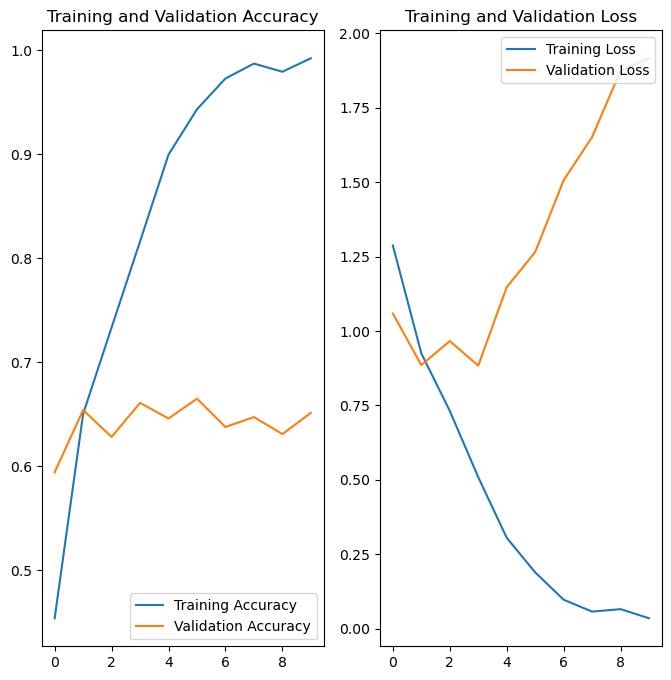

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal', input_shape = (img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)]
)

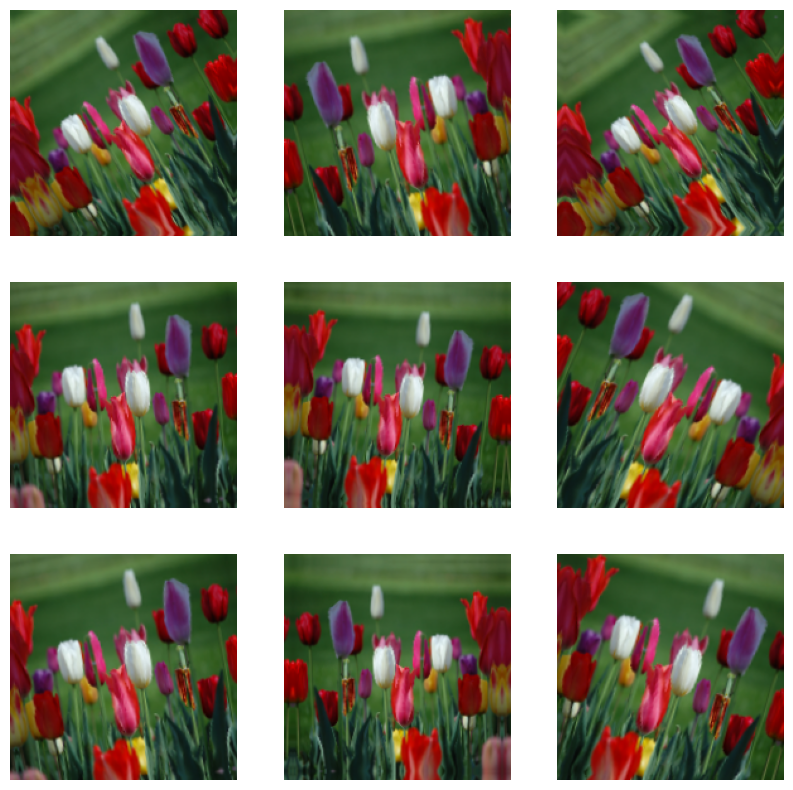

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [21]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes, name = 'outputs')
])

In [22]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.3145 - loss: 1.6745 - val_accuracy: 0.4959 - val_loss: 1.1644
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.4981 - loss: 1.1612 - val_accuracy: 0.5913 - val_loss: 1.0370
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.5993 - loss: 0.9979 - val_accuracy: 0.6376 - val_loss: 0.9141
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.6435 - loss: 0.9156 - val_accuracy: 0.6471 - val_loss: 0.8938
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.6699 - loss: 0.8587 - val_accuracy: 0.6308 - val_loss: 0.9246
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.7018 - loss: 0.7912 - val_accuracy: 0.6798 - val_loss: 0.7937
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 238ms/step - accuracy: 0.7106 - loss: 0.7531 - val_accuracy: 0.7180 - val_loss: 0.7702
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.7232 - loss: 0.7371 - val_accu

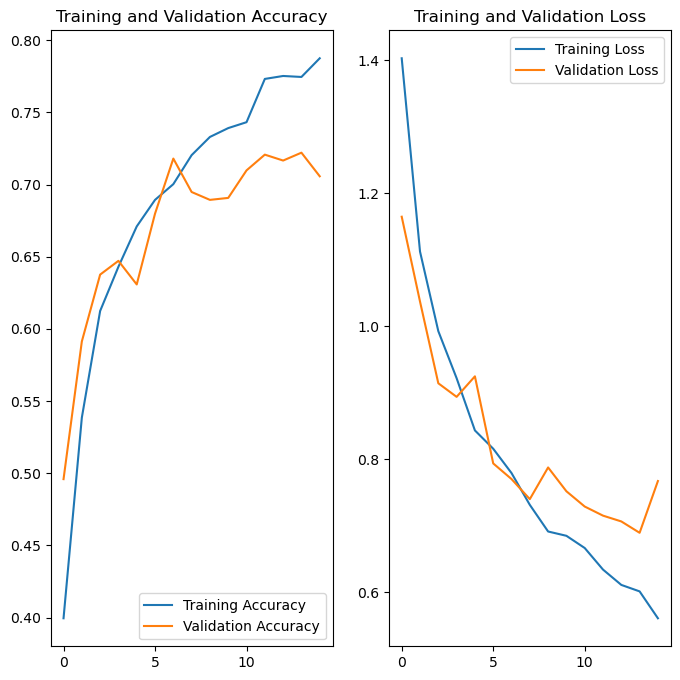

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
This image most likely belongs to sunflowers with a 91.57 percent confidence.


In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflitemodel = converter.convert()

with open('model.tflite', 'wb') as t:
    t.write(tflitemodel)

INFO:tensorflow:Assets written to: C:\Users\muham\AppData\Local\Temp\tmpfqlid80p\assets


INFO:tensorflow:Assets written to: C:\Users\muham\AppData\Local\Temp\tmpfqlid80p\assets


Saved artifact at 'C:\Users\muham\AppData\Local\Temp\tmpfqlid80p'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_15')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  1818565204048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1818565207696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1818565213264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1818565208464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1818565209040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1818565208848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1818565204816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1818565207504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1818565207120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1817040968720: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [27]:
tf_model_path = 'model.tflite'
pre_interpreter = tf.lite.Interpreter(model_path = tf_model_path)
classify_lite = pre_interpreter.get_signature_runner('serving_default')

In [29]:
pre_interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor_15'], 'outputs': ['output_0']}}

In [31]:
logits_light = classify_lite(img_array)['outputs']
predictions_lite = tf.nn.softmax(logits_lite)

TypeError: SignatureRunner.__call__() takes 1 positional argument but 2 were given